# Part 2: Characterization of the community structure of real networks

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from utils import write_pajek_communities, read_pajek_communities, infomap_to_networkx_communities, evaluate_partition
import infomap as im
import itertools

In [3]:
# Read unweighted and weighted networks from Pajek files along with metadata
G_u = nx.read_pajek("primaryschoolnetworks/primaryschool_u.net")
G_w = nx.read_pajek("primaryschoolnetworks/primaryschool_w.net")

# Read metadata from the txt file
metadata = {}
with open("primaryschoolnetworks/metadata_primary_school.txt", "r") as f:
    next(f)  # Skip header line
    for line in f:
        node, group = line.strip().split()
        metadata[node] = group

# Add metadata as node attributes
nx.set_node_attributes(G_u, metadata, "school_group")
nx.set_node_attributes(G_w, metadata, "school_group")

# Print basic information about both networks
print("Unweighted network:")
print(f"Number of nodes: {G_u.number_of_nodes()}")
print(f"Number of edges: {G_u.number_of_edges()}")
print("\nWeighted network:")
print(f"Number of nodes: {G_w.number_of_nodes()}")
print(f"Number of edges: {G_w.number_of_edges()}")

# Print unique school groups and their sizes
school_groups = {}
for node in G_u.nodes():
    group = G_u.nodes[node]["school_group"]
    school_groups[group] = school_groups.get(group, 0) + 1

print("\nSchool groups distribution:")
for group, count in sorted(school_groups.items()):
    print(f"{group}: {count} people")

Unweighted network:
Number of nodes: 242
Number of edges: 8317

Weighted network:
Number of nodes: 242
Number of edges: 8317

School groups distribution:
1A: 23 people
1B: 25 people
2A: 23 people
2B: 26 people
3A: 23 people
3B: 22 people
4A: 21 people
4B: 23 people
5A: 22 people
5B: 24 people
Teachers: 10 people


In [4]:
def set_color_nodes(communities,G):
    colors=plt.cm.jet(np.linspace(0,1,len(communities))) ## Get the colors for the communities
    community_node={} ## Dictionary to store the community of each node
    count_community=0 ## Counter for the communities' labels

    for community in communities: ## For each community
        for node in community: ## For each node in the community
            community_node[node]=count_community ## Store the label of the community of the node
        count_community=count_community+1 ## Update the counter

    color_nodes=[] ## List to store the color of each node
    for node in G.nodes():  
        color_nodes.append(colors[community_node[node]]) ## Get the color of the node

    return color_nodes


def run_infomap(G, use_weight=True):
    """
    Runs the Infomap algorithm on graph G.
    
    Parameters:
      G (networkx.Graph): The input graph.
      use_weight (bool): Whether to consider edge weights or run on an unweighted version.
      
    Returns:
      communities: List of sets (communities detected by Infomap)
    """
    im_wrapper = im.Infomap(silent=True)
    # When weights are not used, we pass weight=None so that each edge is treated equally.
    if use_weight:
        mapping = im_wrapper.add_networkx_graph(G)
    else:
        mapping = im_wrapper.add_networkx_graph(G, weight=None)
    im_wrapper.run()
    partition = im_wrapper.get_modules()
    communities = infomap_to_networkx_communities(mapping, partition)
    return communities

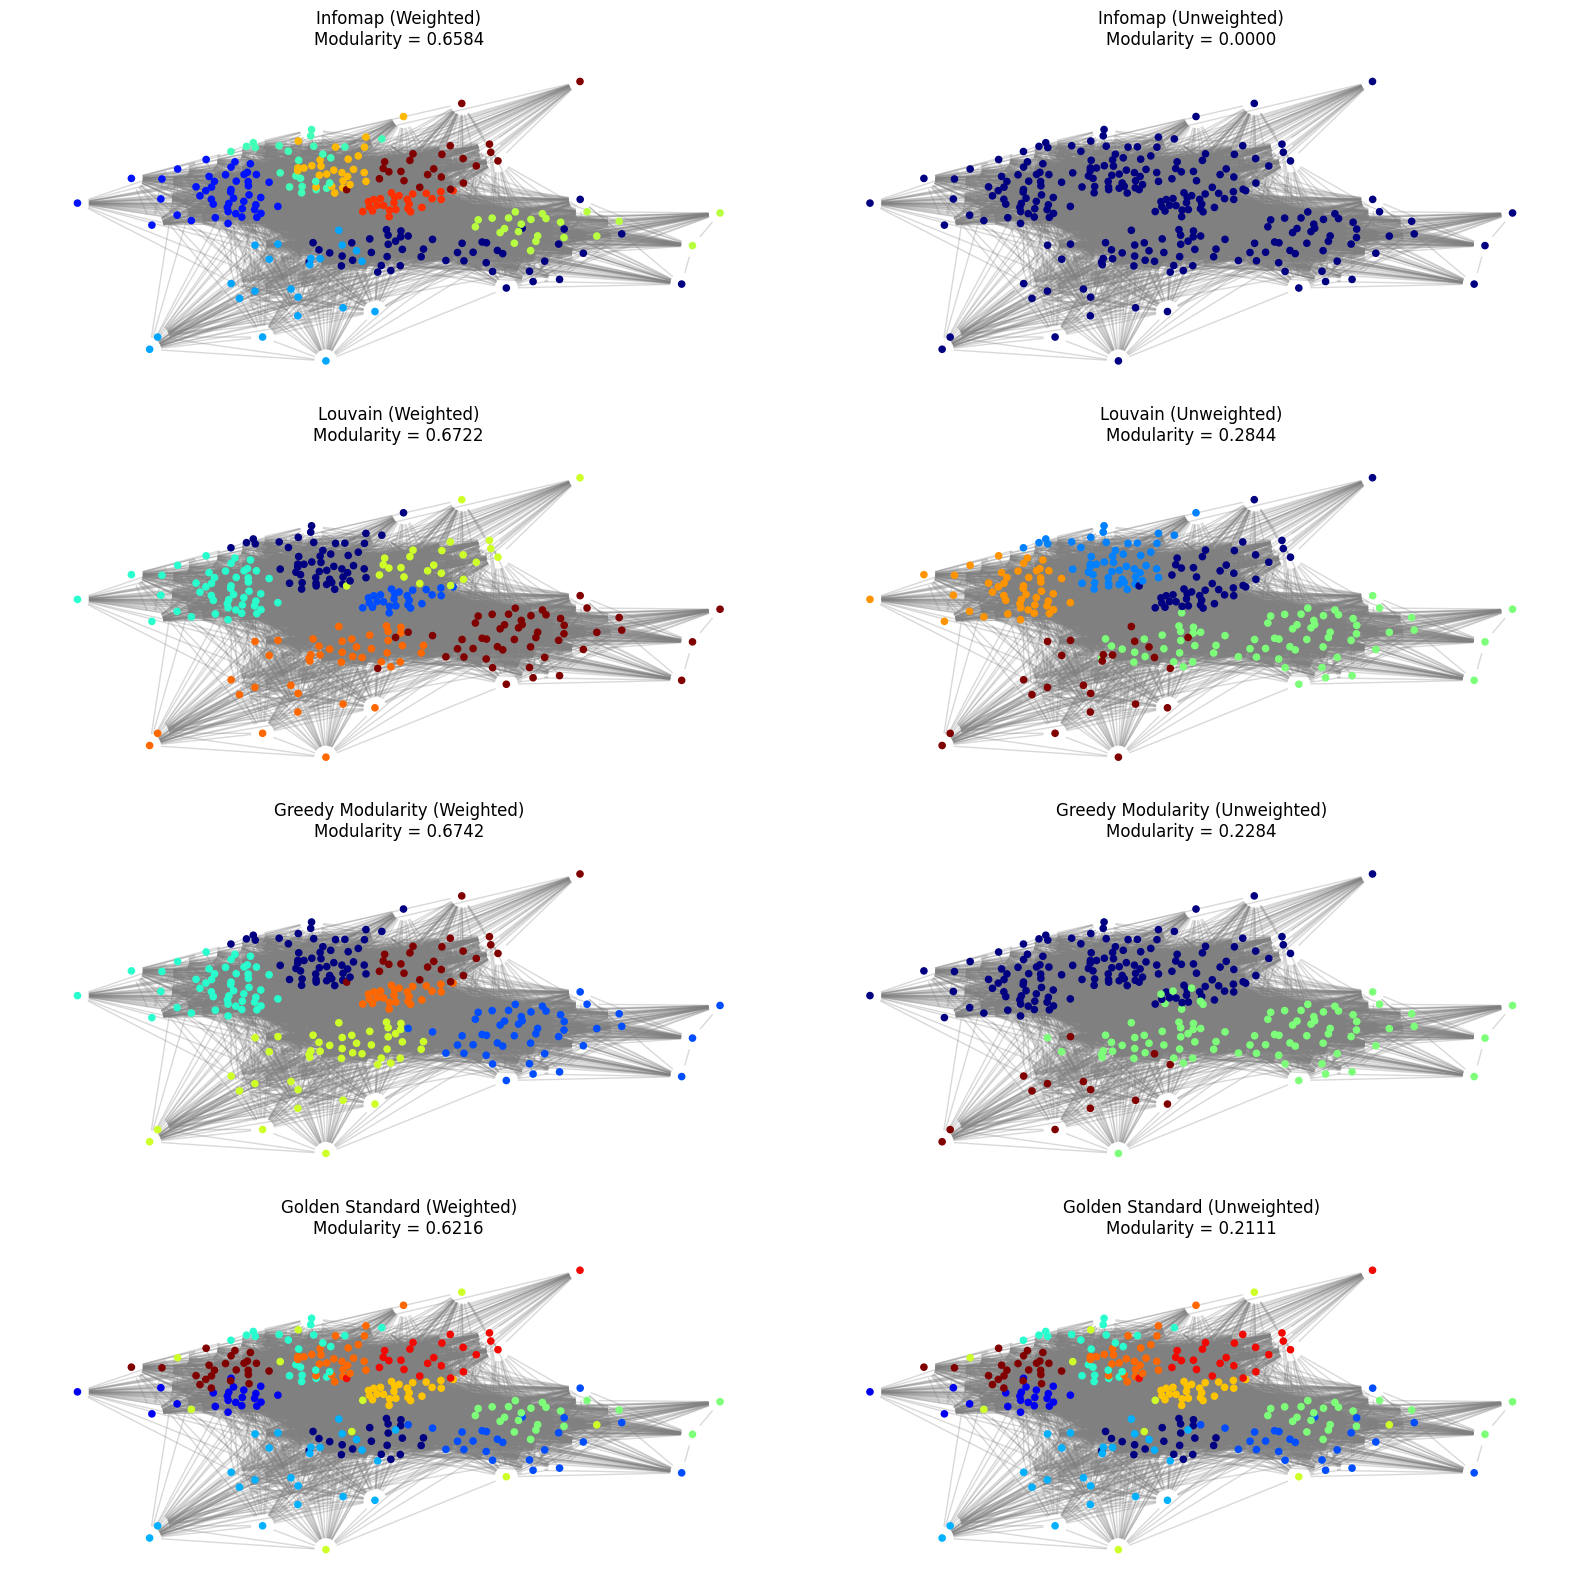

In [6]:

def metadata_to_communities(G, attribute="school_group"):
    """
    Converts node metadata into a community structure.
    
    Parameters:
        G (networkx.Graph): The input graph with metadata stored as node attributes.
        attribute (str): The key used to extract the metadata (default is "school_group").
        
    Returns:
        communities (list of sets): A list of communities, where each community is a set
                                    of nodes that share the same metadata value.
    """
    communities = {}
    for node in G.nodes():
        group = G.nodes[node].get(attribute)
        if group is not None:
            if group not in communities:
                communities[group] = set()
            communities[group].add(node)
    # Return only the sets of nodes (discard the keys)
    return list(communities.values())




def compare_all_community_structures(G_u, G_w, methods):
    """
    Computes several community detection partitions on the weighted and unweighted versions
    of the network and plots them for comparison. Each row corresponds to a method (Infomap,
    Louvain, Greedy Modularity, Golden Standard) and each row has two columns: left is for the
    weighted graph partition and right is for the unweighted one.
    
    Parameters:
      G_u (networkx.Graph): Unweighted version of the graph.
      G_w (networkx.Graph): Weighted version of the graph.
      methods (list): List of community detection methods to be compared.
    
    Returns:
      None (displays a matplotlib figure).
    """
    # --- Prepare layout using the weighted graph.
    # Compute an "inverse weight" attribute (to use with Kamada–Kawai layout)
    for u, v, data in G_w.edges(data=True):
        weight = data.get('weight', 1)
        data['inv_weight'] = 1.0 / weight if weight != 0 else 0.0
    pos = nx.kamada_kawai_layout(G_w, weight='inv_weight')

    
    # --- Plotting.
    # Create a figure with one row per method and two columns.
    num_methods = len(methods)
    fig, axes = plt.subplots(num_methods, 2, figsize=(16, 4 * num_methods))
    # In case there's only one method, ensure axes is 2D.
    if num_methods == 1:
        axes = np.array([axes])

    for i, (method_name, (comm_w, comm_u)) in enumerate(methods.items()):
        # Get node colors for the weighted and unweighted community partitions.
        colors_weighted = set_color_nodes(comm_w, G_w)
        colors_unweighted = set_color_nodes(comm_u, G_w)
        
        # Compute modularity for quality assessment.
        mod_weighted = nx.algorithms.community.modularity(G_w, comm_w, weight='weight')
        mod_unweighted = nx.algorithms.community.modularity(G_u, comm_u, weight=None)
        
        # Plot weighted network.
        ax_left = axes[i, 0]
        nx.draw_networkx_edges(G_w, pos, alpha=0.3, edge_color="gray", ax=ax_left)
        nx.draw_networkx_nodes(G_w, pos, node_color=colors_weighted, node_size=20, ax=ax_left)
        ax_left.set_title(f"{method_name} (Weighted)\nModularity = {mod_weighted:.4f}")
        ax_left.axis('off')
        
        # Plot unweighted network.
        ax_right = axes[i, 1]
        nx.draw_networkx_edges(G_w, pos, alpha=0.3, edge_color="gray", ax=ax_right)
        nx.draw_networkx_nodes(G_w, pos, node_color=colors_unweighted, node_size=20, ax=ax_right)
        ax_right.set_title(f"{method_name} (Unweighted)\nModularity = {mod_unweighted:.4f}")
        ax_right.axis('off')
        
    plt.tight_layout()
    plt.show()

community_golden_standard = metadata_to_communities(G_u, attribute="school_group")

# --- Compute community partitions.
# Infomap communities.
communities_infomap_weighted = run_infomap(G_w, use_weight=True)
communities_infomap_unweighted = run_infomap(G_u, use_weight=False)

# Louvain communities. (Note: the unweighted detection is done by not passing a weight.)
communities_louvain_weighted = nx.community.louvain_communities(G_w, weight='weight')
communities_louvain_unweighted = nx.community.louvain_communities(G_u)

# Greedy modularity communities.
communities_greedy_weighted = nx.community.greedy_modularity_communities(G_w, weight='weight')
communities_greedy_unweighted = nx.community.greedy_modularity_communities(G_u)

# Golden standard communities (from metadata).
# Here we assume that the golden standard groups are defined independently of weighting.
communities_golden_weighted = community_golden_standard
communities_golden_unweighted = community_golden_standard



# Create a dictionary to easily loop over the community detection methods.
methods = {
    "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
    "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
    "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
    "Golden Standard": (communities_golden_weighted, communities_golden_unweighted)
}


compare_all_community_structures(G_u, G_w, methods)

In [7]:

# Save communities to Pajek files
for name, (weighted_comm, unweighted_comm) in methods.items():
    # Save weighted communities
    write_pajek_communities(weighted_comm, f"PSN/PSN_{name}_weighted.clu")
    # Save unweighted communities
    write_pajek_communities(unweighted_comm, f"PSN/PSN_{name}_unweighted.clu")

Plotting for Infomap - Weighted communities


<Figure size 1000x600 with 0 Axes>

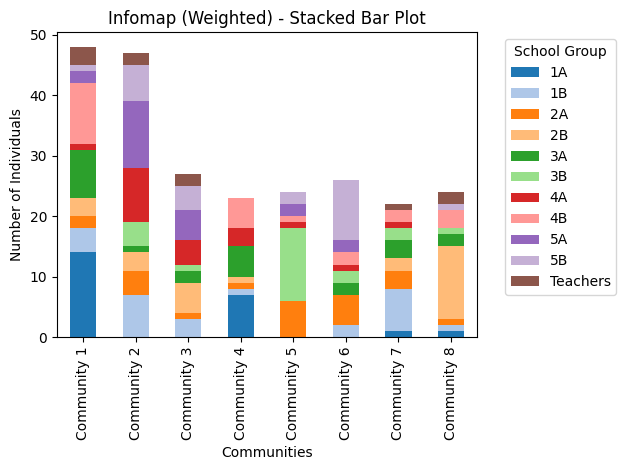

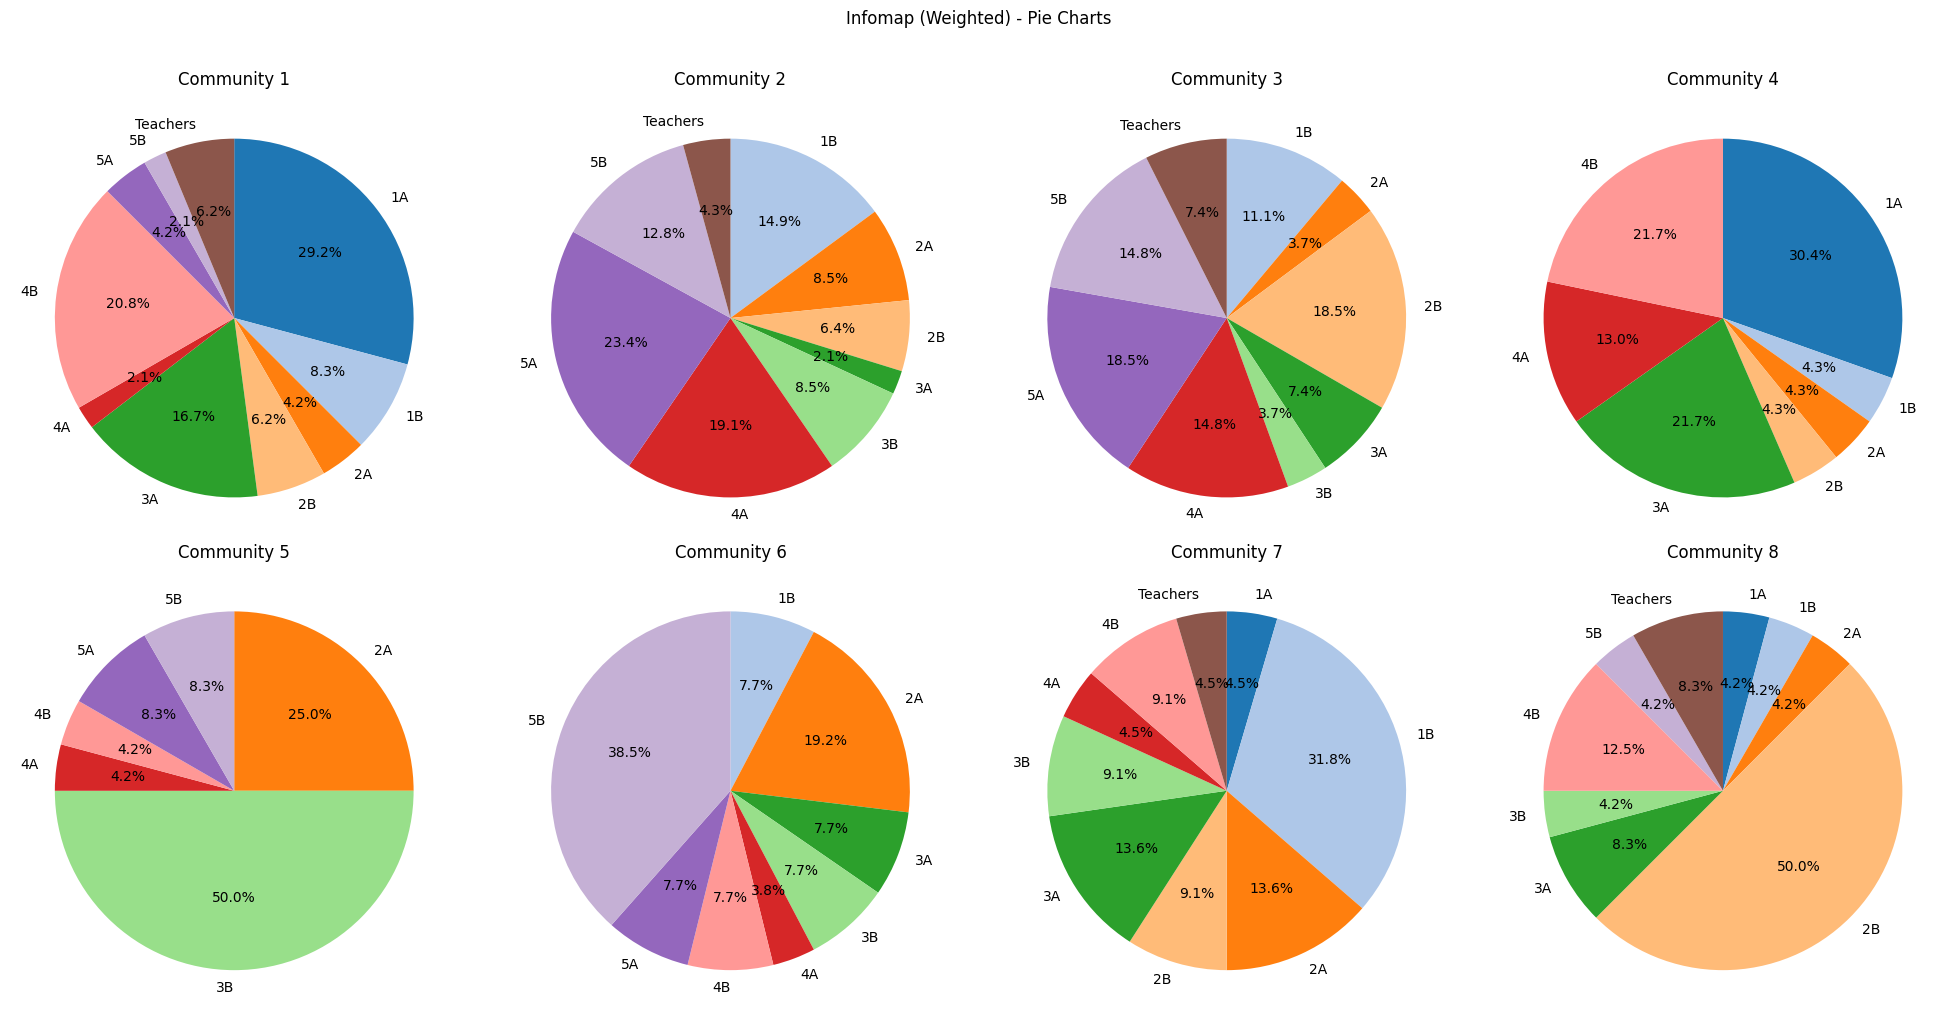

<Figure size 1000x600 with 0 Axes>

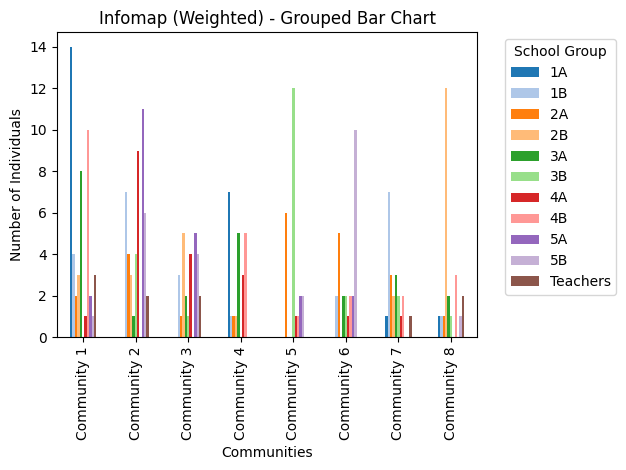

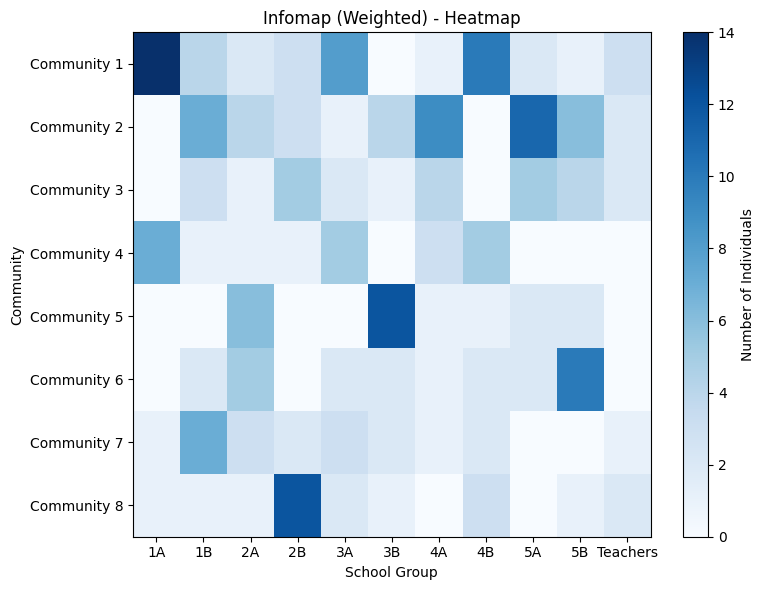

Plotting for Infomap - Unweighted communities


<Figure size 1000x600 with 0 Axes>

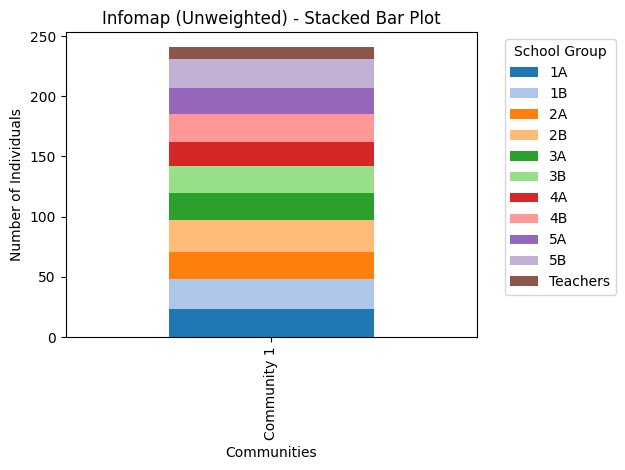

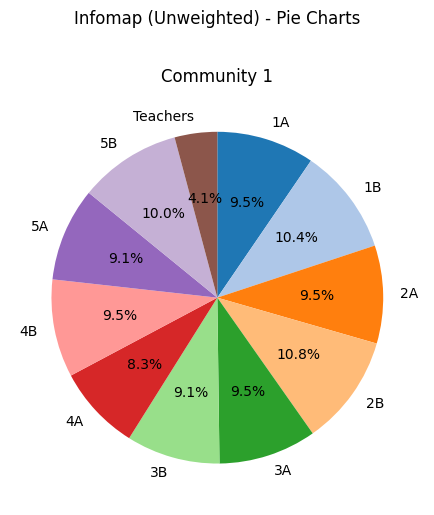

<Figure size 1000x600 with 0 Axes>

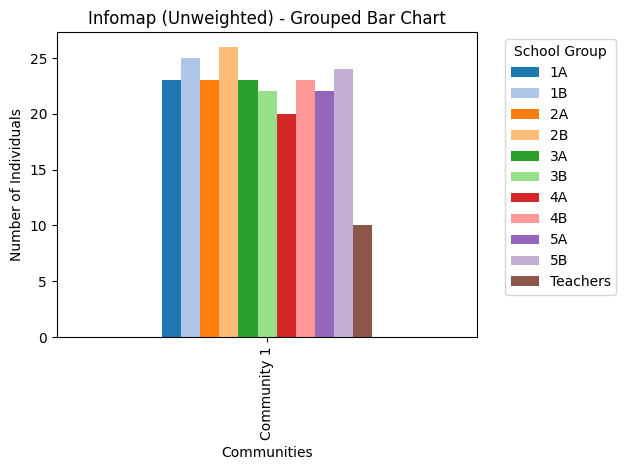

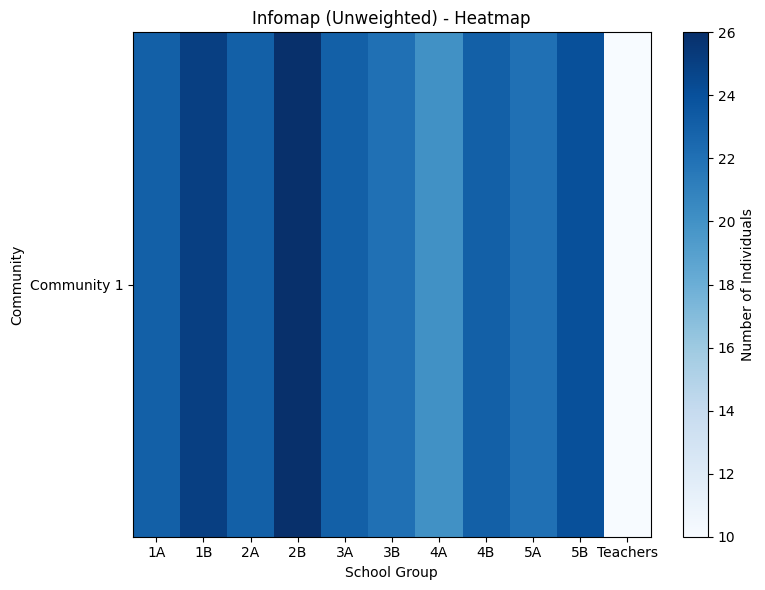

Plotting for Louvain - Weighted communities


<Figure size 1000x600 with 0 Axes>

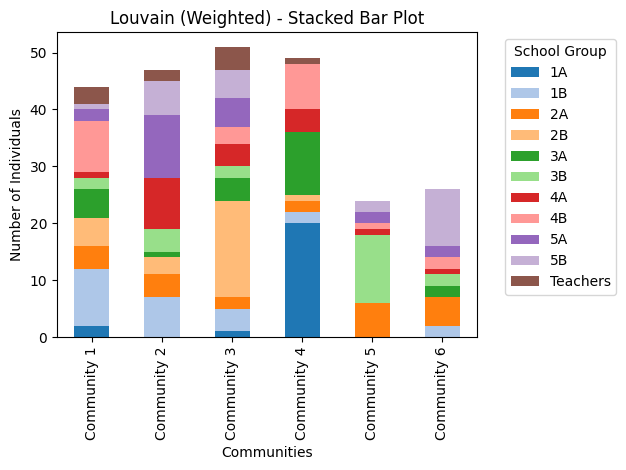

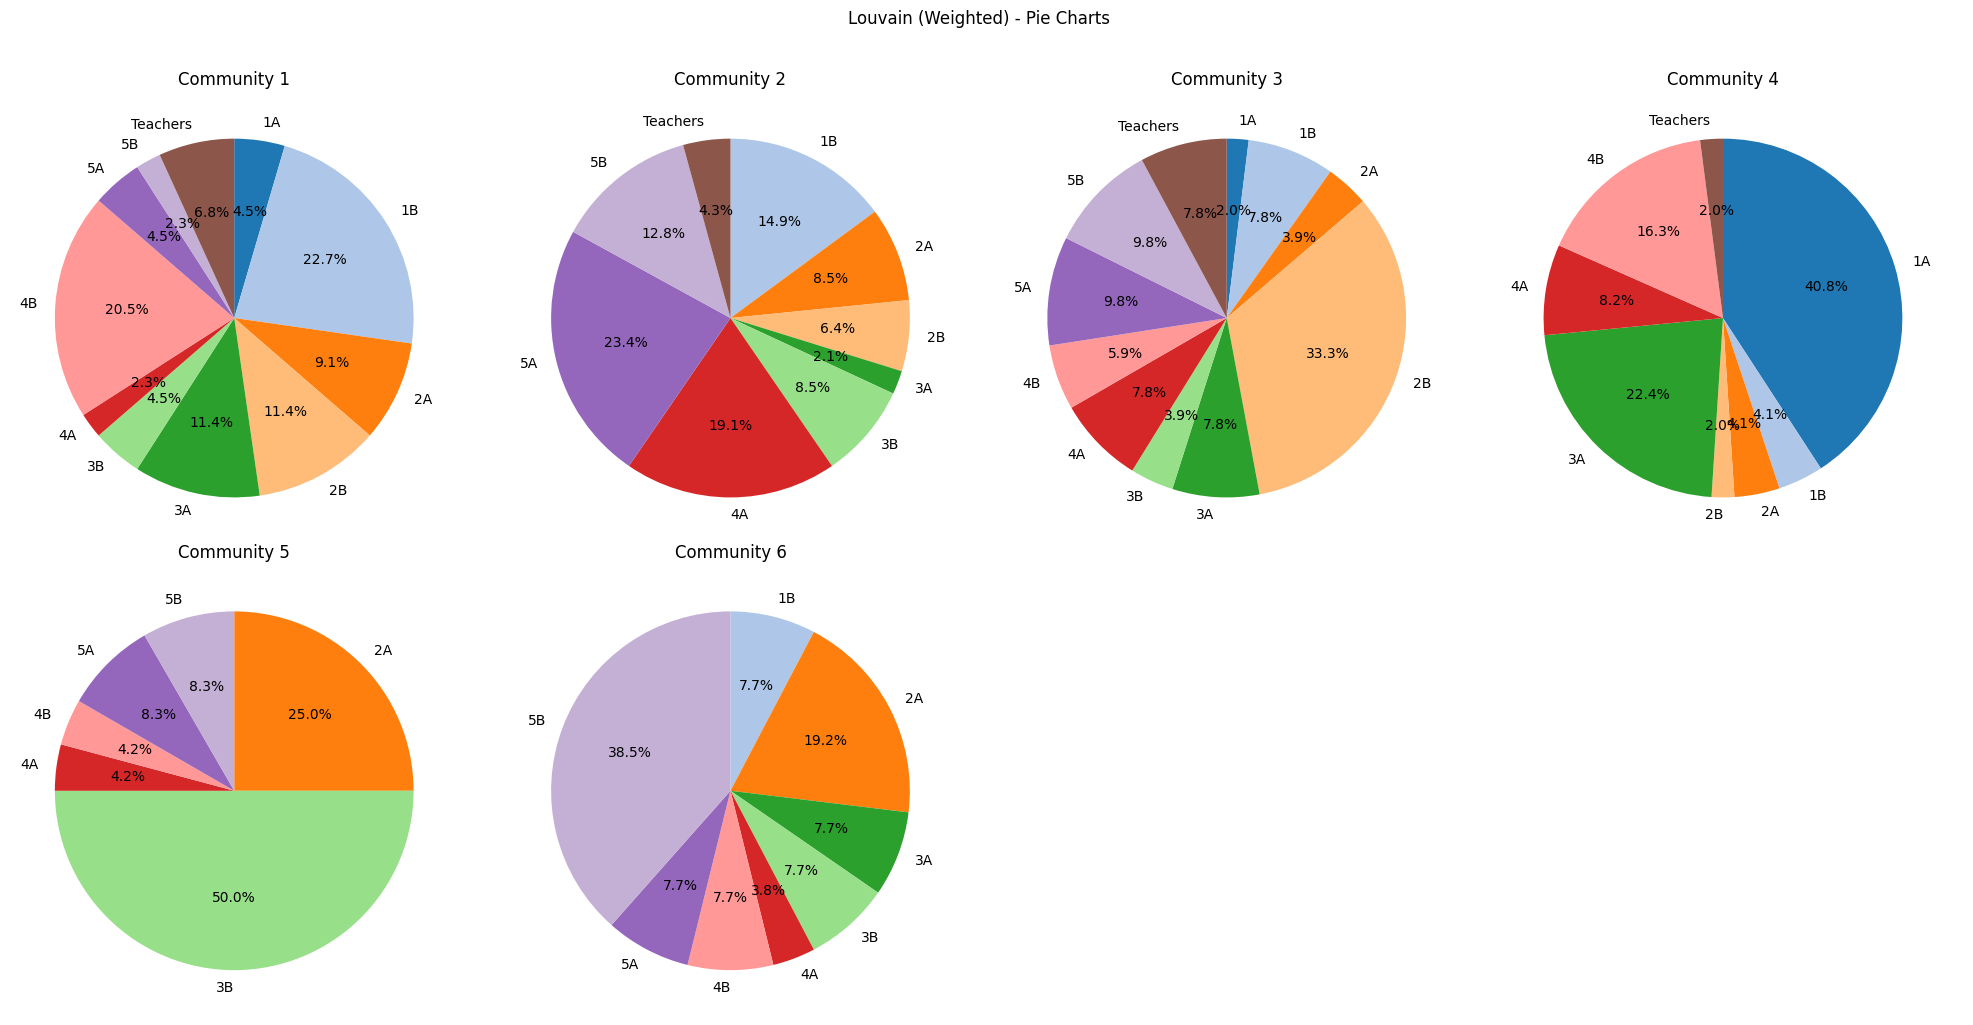

<Figure size 1000x600 with 0 Axes>

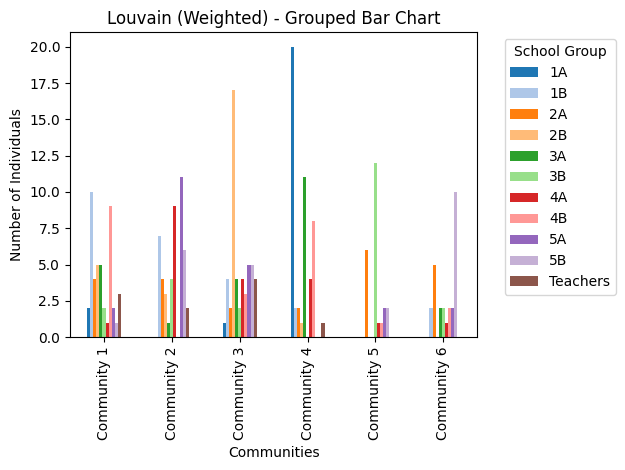

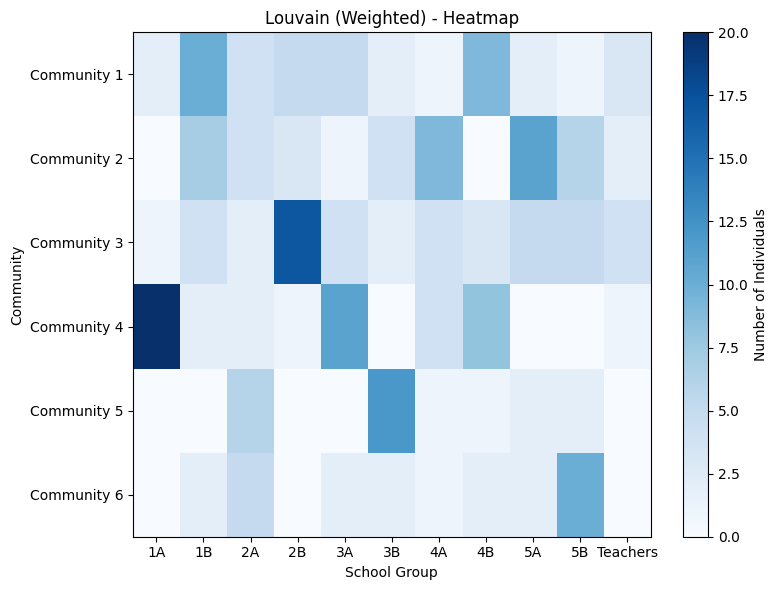

Plotting for Louvain - Unweighted communities


<Figure size 1000x600 with 0 Axes>

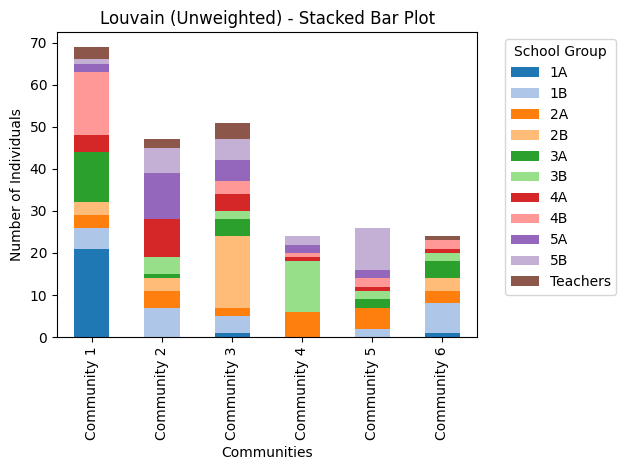

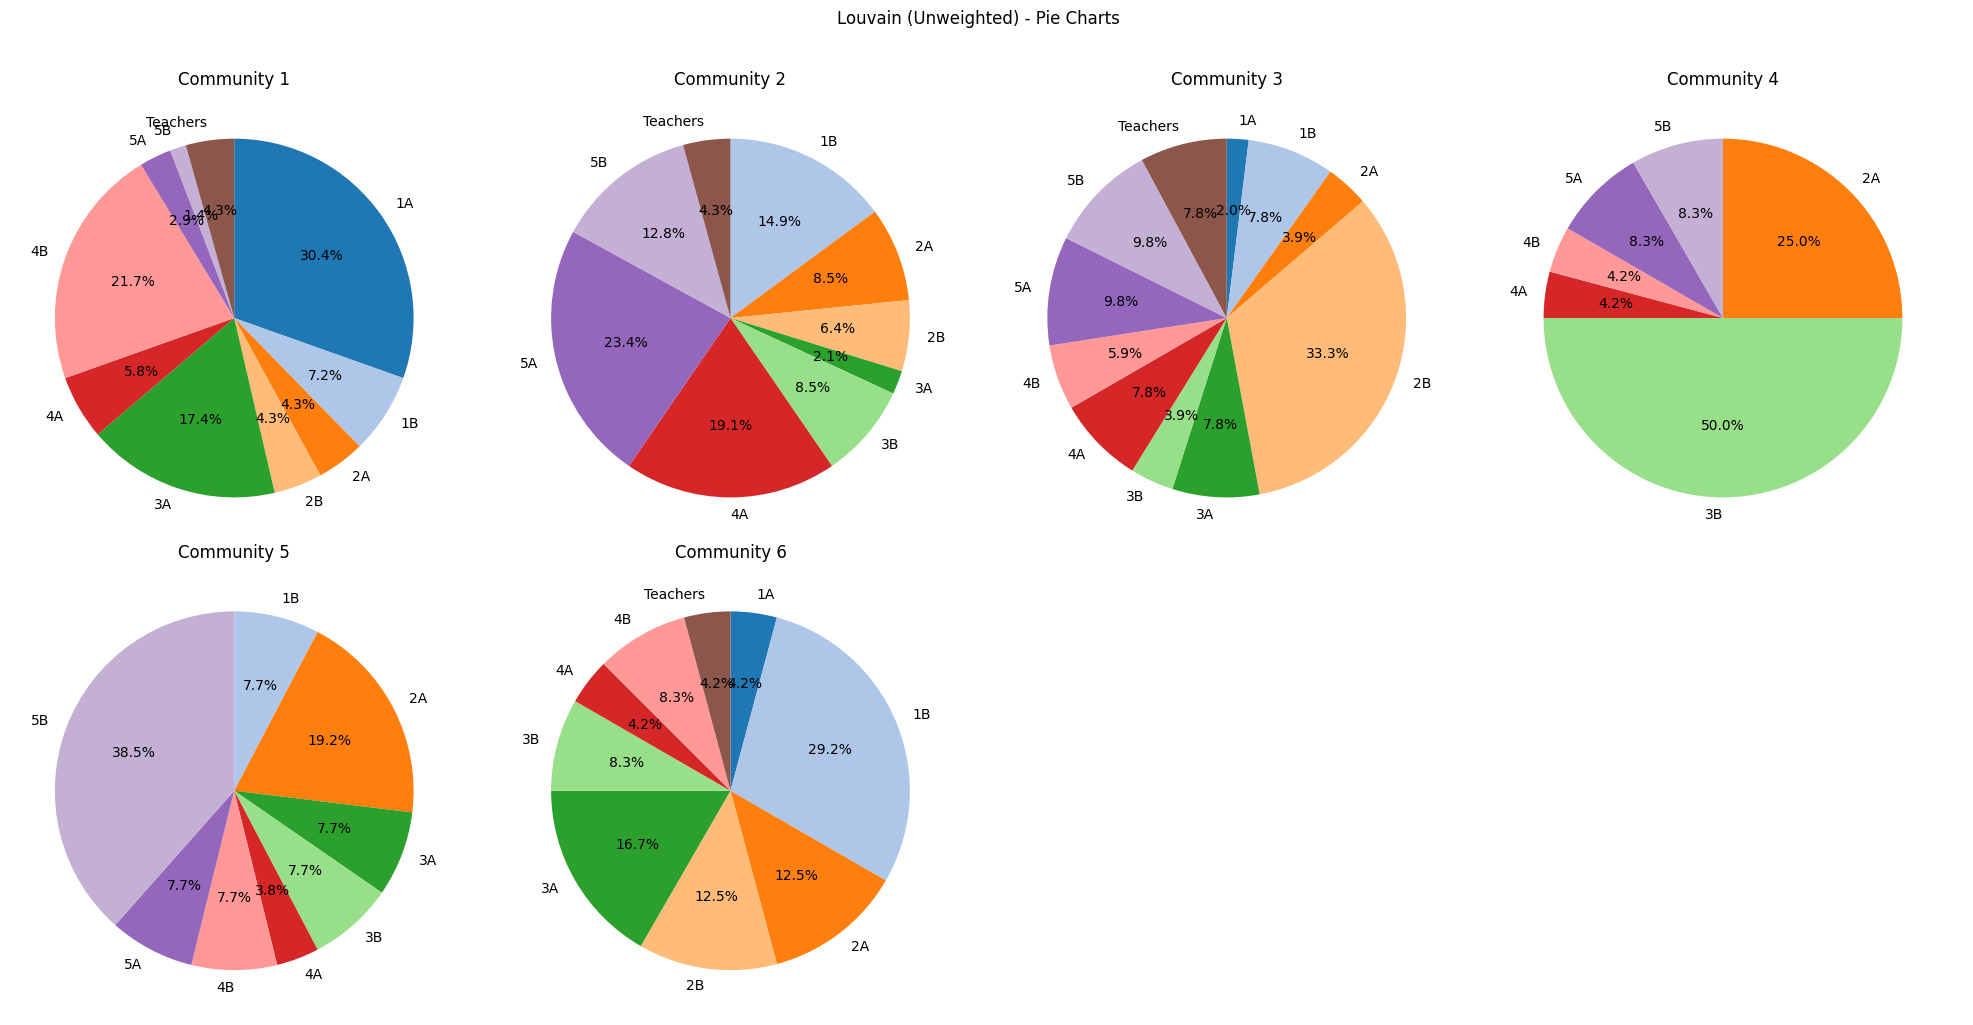

<Figure size 1000x600 with 0 Axes>

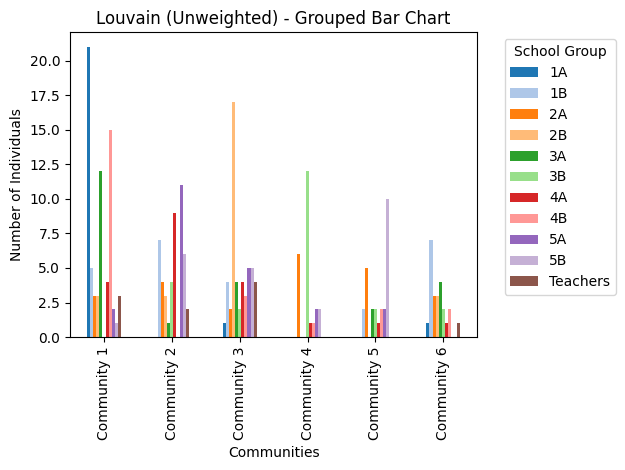

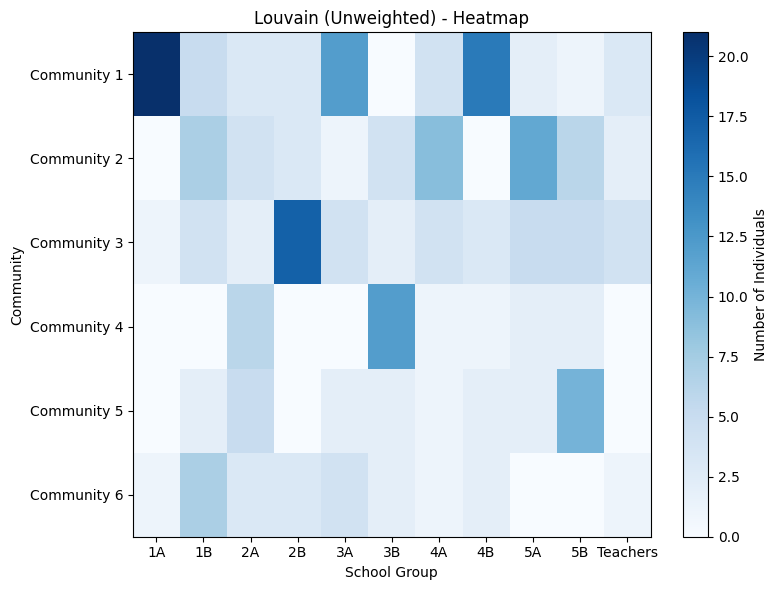

Plotting for Greedy Modularity - Weighted communities


<Figure size 1000x600 with 0 Axes>

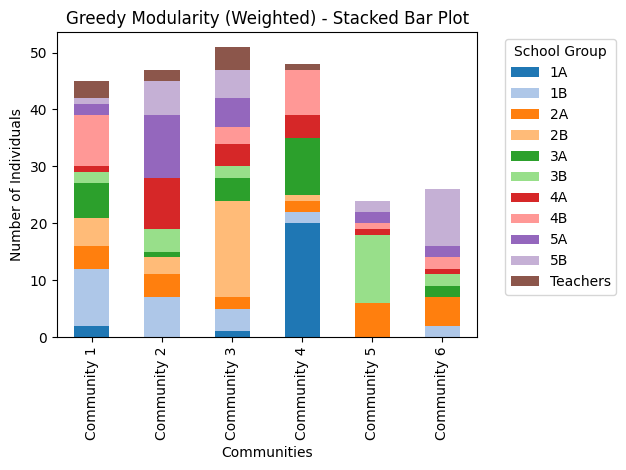

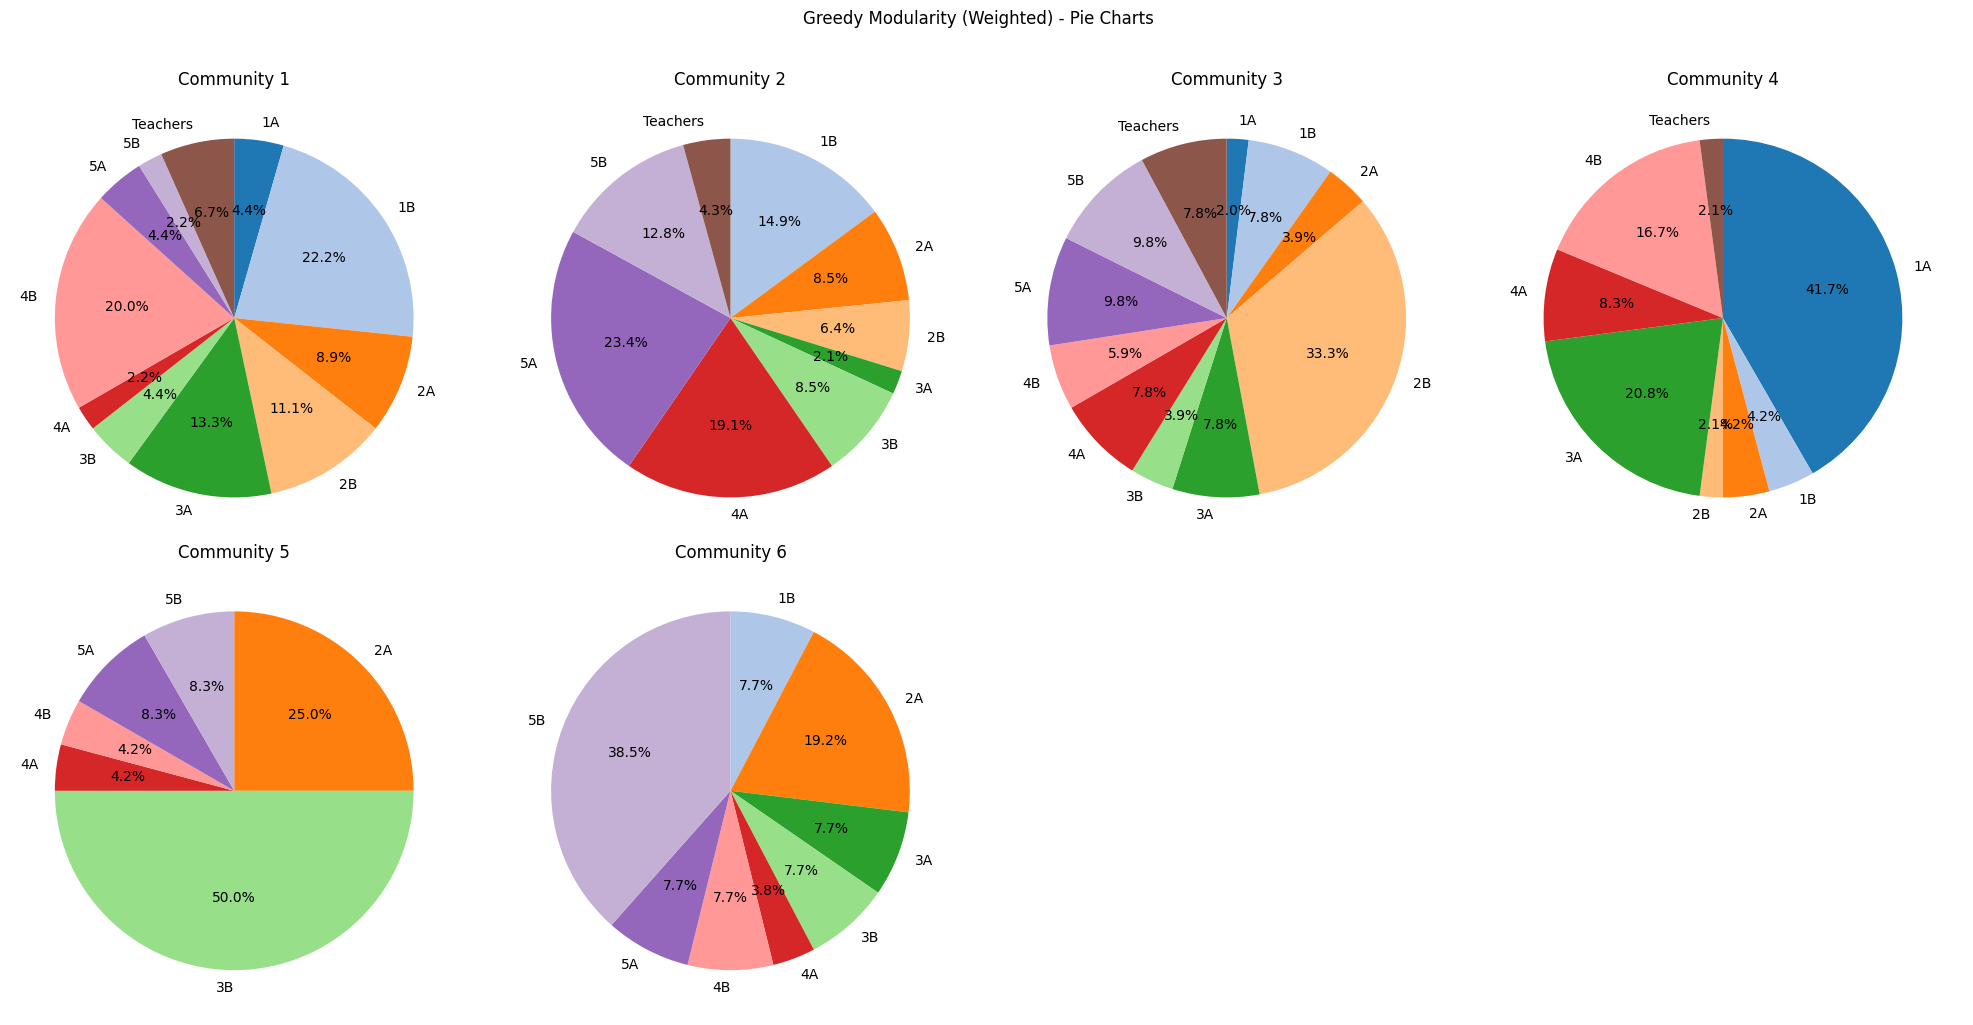

<Figure size 1000x600 with 0 Axes>

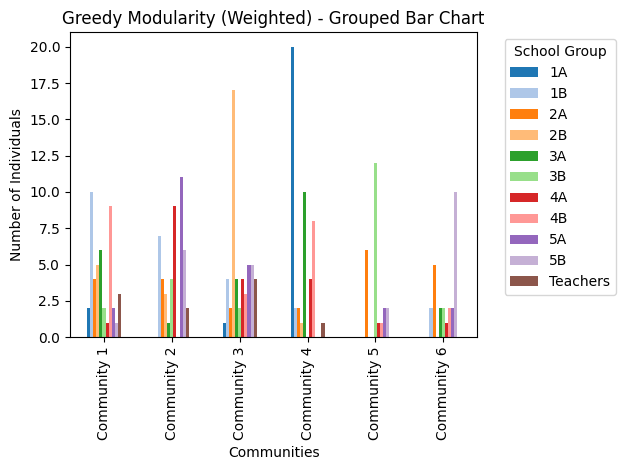

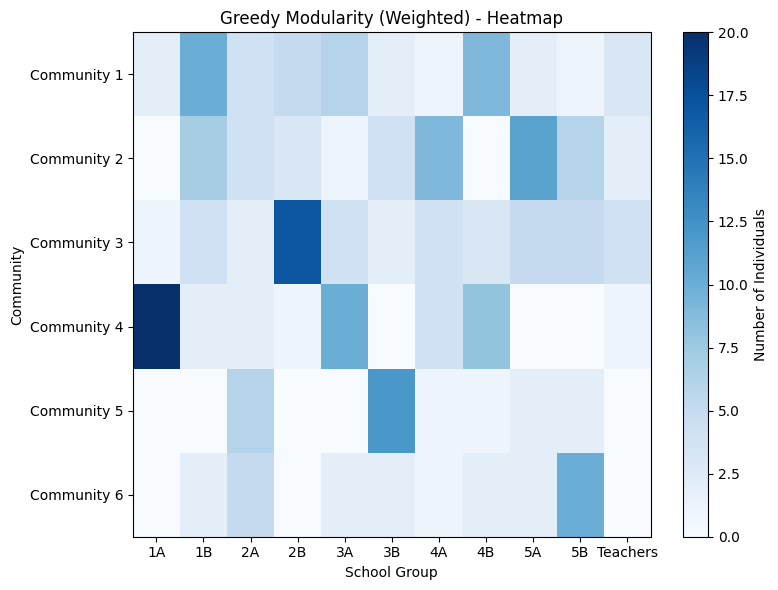

Plotting for Greedy Modularity - Unweighted communities


<Figure size 1000x600 with 0 Axes>

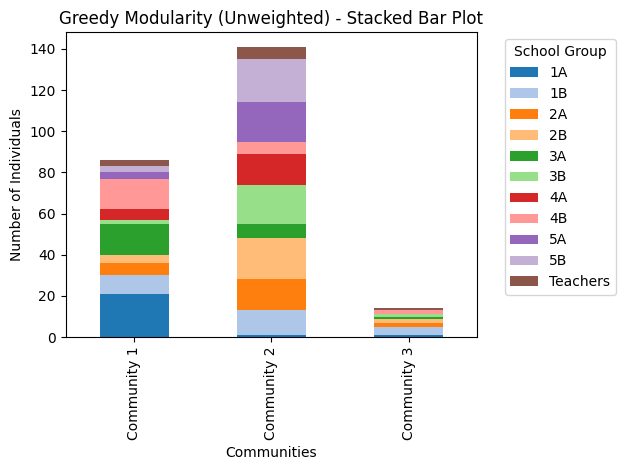

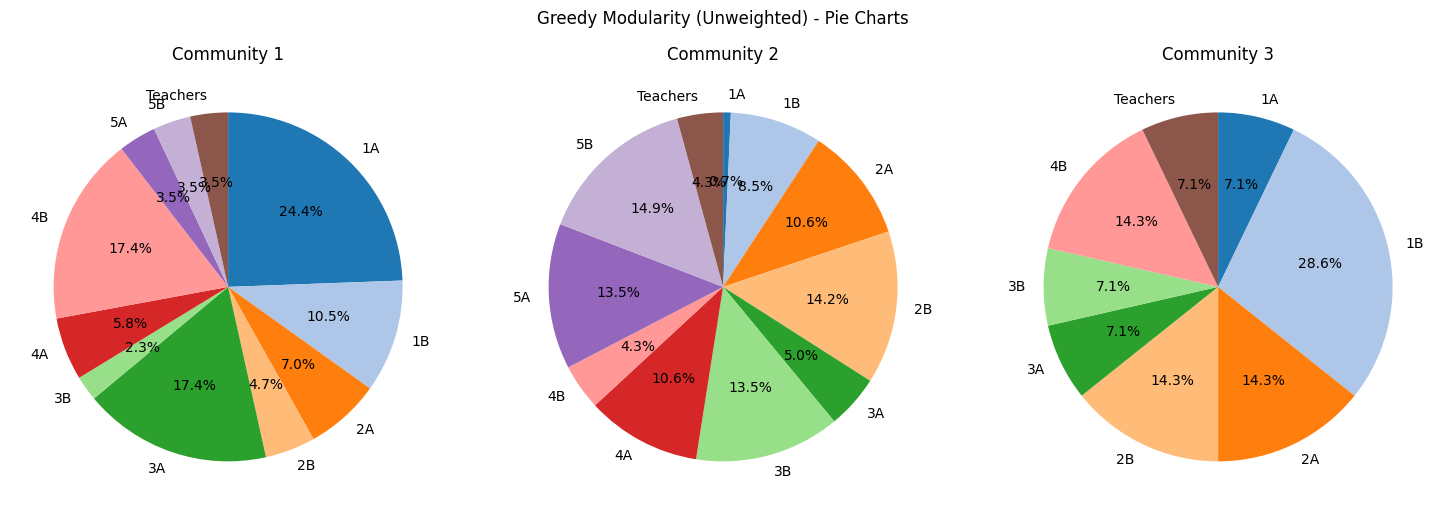

<Figure size 1000x600 with 0 Axes>

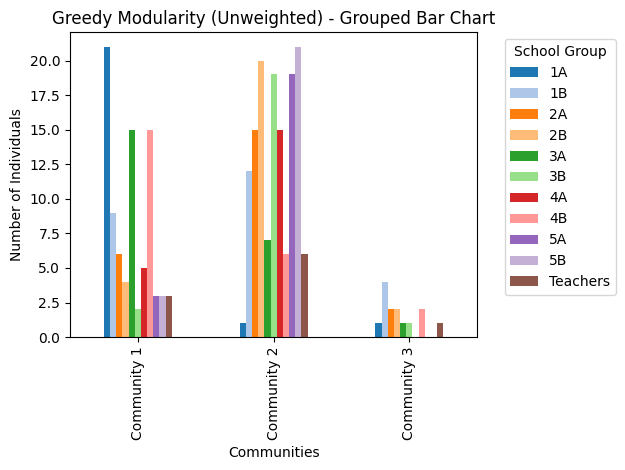

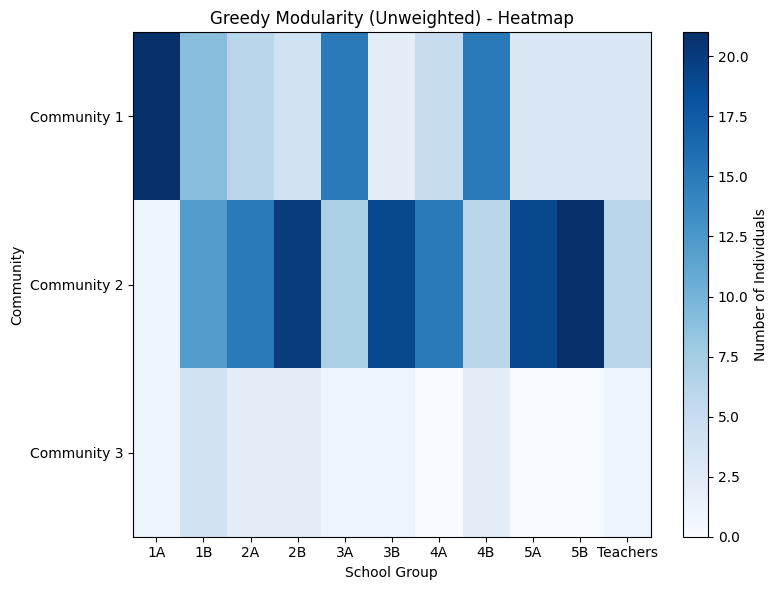

In [8]:
import pandas as pd
from collections import Counter

def plot_school_group_composition(communities, group_assignment, title_prefix="Community Composition by School Groups"):
    """
    Generates four different plots showing the composition of detected communities
    in terms of the school groups to which their individuals belong, using consistent
    colors for each school group.
    
    Parameters:
        communities (list of sets/lists): Detected communities, where each community is a collection of node identifiers.
        group_assignment (dict): Dictionary mapping each node to its corresponding school group.
        title_prefix (str): A prefix for the titles of the plots.
    
    The function produces:
      1. A Stacked Bar Plot.
      2. A set of Pie Charts (one per community).
      3. A Grouped Bar Chart.
      4. A Heatmap.
    """
    # Determine all unique school groups.
    all_groups = sorted(set(group_assignment.values()))
    
    # Generate a consistent color mapping for each school group.
    # Use a qualitative colormap ("tab10" for ≤10 groups, otherwise "tab20")
    cmap = plt.get_cmap("tab10") if len(all_groups) <= 10 else plt.get_cmap("tab20")
    color_mapping = {group: cmap(i) for i, group in enumerate(all_groups)}
    
    # Build a DataFrame where each row represents a community and each column a school group.
    community_labels = [f"Community {i+1}" for i in range(len(communities))]
    data = []
    for community in communities:
        # Map nodes to their school groups.
        community_groups = map(lambda x: group_assignment.get(str(x)), list(community))
        # Count the number of individuals in each group within the community.
        counts = Counter(community_groups)
        # Ensure all groups are represented in the counts, even if zero.
        counts = {group: counts.get(group, 0) for group in all_groups}
        data.append(counts)
    df = pd.DataFrame(data, index=community_labels)[all_groups]
    
    # -------------------------------
    # Plot 1: Stacked Bar Plot
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', stacked=True, color=[color_mapping[group] for group in all_groups])
    plt.title(f"{title_prefix} - Stacked Bar Plot")
    plt.xlabel("Communities")
    plt.ylabel("Number of Individuals")
    plt.legend(title="School Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 2: Pie Charts for Each Community
    num_com = len(df.index)
    cols = min(num_com, 4)  # up to 4 columns
    rows = int(np.ceil(num_com / cols))
    fig2, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = np.atleast_1d(axs).flatten()
    
    for i, community in enumerate(df.index):
        ax = axs[i]
        counts = df.loc[community]
        counts = counts[counts > 0]  # drop zero counts for clarity
        
        # Ensure the pie chart uses consistent colors based on the school group.
        colors = [color_mapping[group] for group in counts.index]
        counts.plot(kind='pie', ax=ax, autopct='%1.1f%%',
                    startangle=90, counterclock=False, colors=colors)
        ax.set_ylabel("")
        ax.set_title(community)
    
    # Turn off any unused subplots.
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    fig2.suptitle(f"{title_prefix} - Pie Charts", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 3: Grouped (Side-by-Side) Bar Chart
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', color=[color_mapping[group] for group in all_groups])
    plt.title(f"{title_prefix} - Grouped Bar Chart")
    plt.xlabel("Communities")
    plt.ylabel("Number of Individuals")
    plt.legend(title="School Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 4: Heatmap of the Composition
    # Note: The heatmap represents counts using a continuous color scale
    plt.figure(figsize=(8, 6))
    im = plt.imshow(df.values, cmap='Blues', aspect='auto')
    plt.xticks(ticks=np.arange(len(all_groups)), labels=all_groups)
    plt.yticks(ticks=np.arange(len(community_labels)), labels=community_labels)
    plt.xlabel("School Group")
    plt.ylabel("Community")
    plt.title(f"{title_prefix} - Heatmap")
    plt.colorbar(im, label="Number of Individuals")
    plt.tight_layout()
    plt.show()

def plot_all_community_compositions(methods, group_assignment):
    """
    Loops over the community detection methods and generates the four plots
    for both the weighted and unweighted community partitions.

    Parameters:
        methods (dict): Dictionary mapping community detection method names to a tuple of
                        (weighted_communities, unweighted_communities).
        group_assignment (dict): Dictionary mapping each node to its corresponding school group.
    """
    for method_name, (weighted_communities, unweighted_communities) in methods.items():
        # Plot for weighted communities
        print(f"Plotting for {method_name} - Weighted communities")
        plot_school_group_composition(weighted_communities, group_assignment, 
                                      title_prefix=f"{method_name} (Weighted)")

        # Plot for unweighted communities
        print(f"Plotting for {method_name} - Unweighted communities")
        plot_school_group_composition(unweighted_communities, group_assignment, 
                                      title_prefix=f"{method_name} (Unweighted)")
    
from utils import read_pajek_communities

# Read communities from Pajek files
communities_infomap_weighted = read_pajek_communities("PSN_Infomap_weighted.clu")
communities_infomap_unweighted = read_pajek_communities("PSN_Infomap_unweighted.clu")
communities_louvain_weighted = read_pajek_communities("PSN_Louvain_weighted.clu")
communities_louvain_unweighted = read_pajek_communities("PSN_Louvain_unweighted.clu")
communities_greedy_weighted = read_pajek_communities("PSN_Greedy Modularity_weighted.clu")
communities_greedy_unweighted = read_pajek_communities("PSN_Greedy Modularity_unweighted.clu")

# Then, define the dictionary of methods:

methods = {
    "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
    "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
    "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
}

plot_all_community_compositions(methods, metadata)

In [9]:


def generate_latex_table_from_communities(methods, G_w, G_u, golden_partition,
                                          caption="Community Detection Metrics for the Primary School Network",
                                          label="tab:real_network"):
    """
    Generates a LaTeX table summarizing community detection results.
    
    For each community detection method (key in methods), this function computes:
      - The number of communities and modularity score for both the weighted and unweighted networks.
      - The Normalized Mutual Information (NMI), normalized Variation of Information (nVI),
        and Jaccard Index (computed against the golden standard partition).
    
    Parameters:
      methods (dict): A dictionary mapping a method name to a tuple
                      (weighted_communities, unweighted_communities) where each is a list of node sets.
      G_w (networkx.Graph): The weighted network used for weighted partitions.
      G_u (networkx.Graph): The unweighted network used for unweighted partitions.
      golden_partition (list of sets): The ground-truth communities.
      caption (str): Caption for the LaTeX table.
      label (str): LaTeX label for table referencing.
      
    Returns:
      A string containing the full LaTeX table.
    """
    table_lines = []
    table_lines.append("\\begin{table}[htbp]")
    table_lines.append("\\centering")
    table_lines.append(f"\\caption{{{caption}}}")
    table_lines.append(f"\\label{{{label}}}")
    # Define column alignment: Method, Network Version, # Communities, Modularity, NMI, nVI, Jaccard Index.
    table_lines.append("\\begin{tabular}{@{}l l c c c c c@{}}")
    table_lines.append("\\toprule")
    table_lines.append("Method & Network Version & \\# Communities & Modularity ($Q$) & NMI & nVI & Jaccard Index \\\\ \\midrule")
    
    # prr is used here as a placeholder (e.g., 0) since it is not the focus of the table;
    # evaluation is done against the golden standard.
    dummy_prr = 0  
    for method, (communities_w, communities_u) in methods.items():
        # Evaluate weighted partition using the weighted graph G_w.
        metrics_w = evaluate_partition(golden_partition, communities_w, G_w, dummy_prr)
        # Evaluate unweighted partition using the unweighted graph G_u.
        metrics_u = evaluate_partition(golden_partition, communities_u, G_u, dummy_prr)
        
        row_w = (f"{method} & Weighted & {metrics_w['num_communities']} & "
                 f"{metrics_w['modularity']:.2f} & {metrics_w['normalized_mutual_information']:.2f} & "
                 f"{metrics_w['normalized_variation_of_information']:.2f} & {metrics_w['jaccard_index']:.2f} \\\\")
        row_u = (f"{method} & Unweighted & {metrics_u['num_communities']} & "
                 f"{metrics_u['modularity']:.2f} & {metrics_u['normalized_mutual_information']:.2f} & "
                 f"{metrics_u['normalized_variation_of_information']:.2f} & {metrics_u['jaccard_index']:.2f} \\\\")
        table_lines.append(row_w)
        table_lines.append(row_u)
    
    table_lines.append("\\bottomrule")
    table_lines.append("\\end{tabular}")
    table_lines.append("\\end{table}")
    
    return "\n".join(table_lines)

communities_infomap_weighted = run_infomap(G_w, use_weight=True)
communities_infomap_unweighted = run_infomap(G_u, use_weight=False)
communities_louvain_weighted = nx.community.louvain_communities(G_w, weight='weight')
communities_louvain_unweighted = nx.community.louvain_communities(G_u)
communities_greedy_weighted = nx.community.greedy_modularity_communities(G_w, weight='weight')
communities_greedy_unweighted = nx.community.greedy_modularity_communities(G_u)


# Then, define the dictionary of methods:

methods = {
    "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
    "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
    "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
}

latex_table = generate_latex_table_from_communities(methods, G_w, G_u, metadata_to_communities(G_u, attribute="school_group"))
print(latex_table)

\begin{table}[htbp]
\centering
\caption{Community Detection Metrics for the Primary School Network}
\label{tab:real_network}
\begin{tabular}{@{}l l c c c c c@{}}
\toprule
Method & Network Version & \# Communities & Modularity ($Q$) & NMI & nVI & Jaccard Index \\ \midrule
Infomap & Weighted & 8 & 0.66 & 0.87 & 0.10 & 0.63 \\
Infomap & Unweighted & 1 & 0.00 & 0.00 & 0.43 & 0.09 \\
Louvain & Weighted & 6 & 0.67 & 0.81 & 0.15 & 0.49 \\
Louvain & Unweighted & 6 & 0.28 & 0.80 & 0.15 & 0.46 \\
Greedy Modularity & Weighted & 6 & 0.67 & 0.81 & 0.14 & 0.50 \\
Greedy Modularity & Unweighted & 3 & 0.23 & 0.43 & 0.33 & 0.17 \\
\bottomrule
\end{tabular}
\end{table}


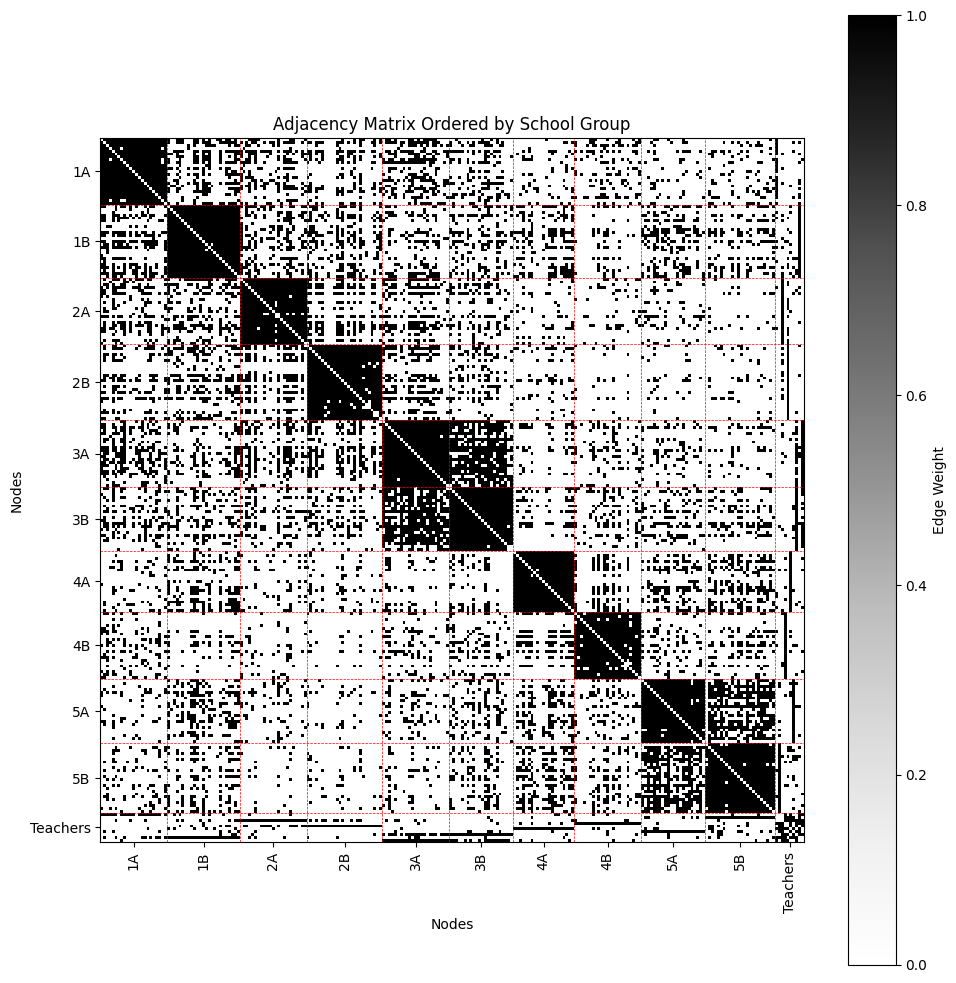

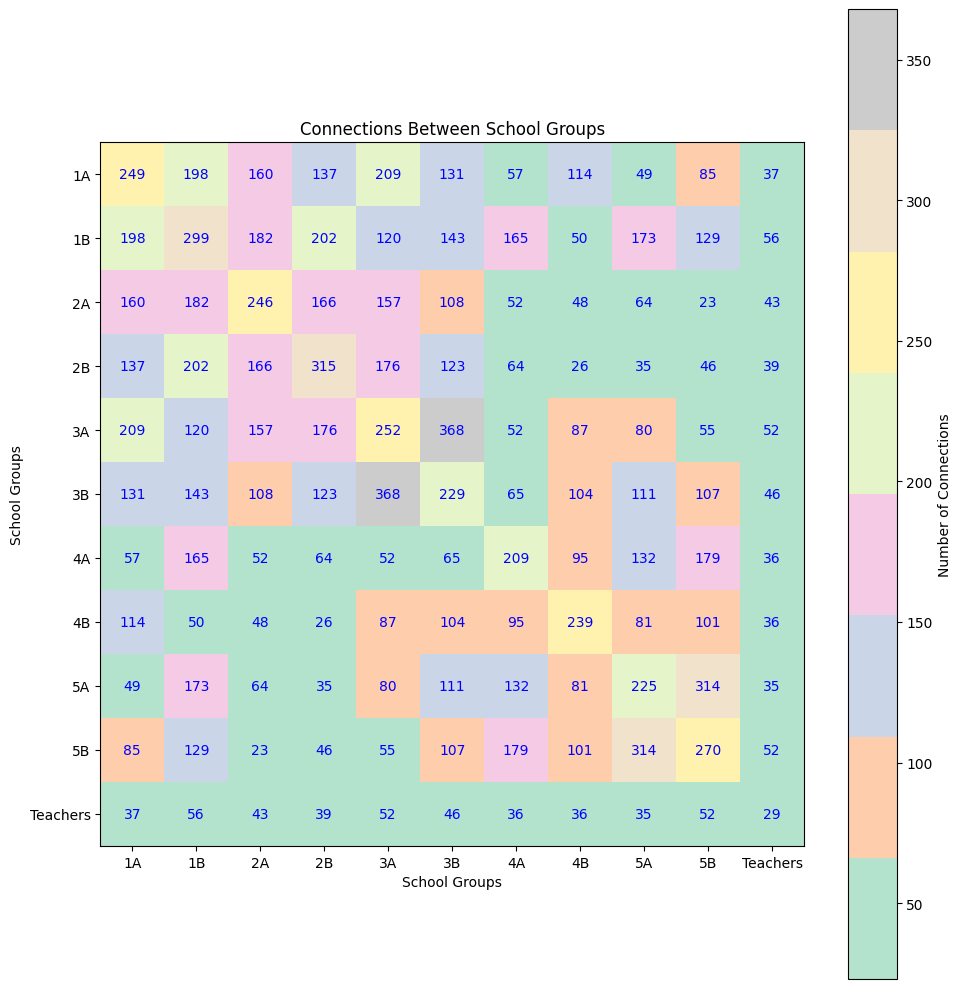

In [10]:

# Order nodes by their school group (using metadata)
sorted_nodes = sorted(G_u.nodes(), key=lambda node: (metadata.get(node, ""), node))

# Get the adjacency matrix of G_u for the sorted nodes
A = nx.to_numpy_array(G_u, nodelist=sorted_nodes)

plt.figure(figsize=(10, 10))
plt.imshow(A, interpolation='none', cmap='Greys')
plt.title("Adjacency Matrix Ordered by School Group")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# Get group labels for the sorted nodes
group_labels = [metadata.get(node, "") for node in sorted_nodes]

# Compute group boundaries and positions for ticks
group_positions = []
boundaries = []
for group, subiter in itertools.groupby(enumerate(group_labels), key=lambda x: x[1]):
    sublist = list(subiter)
    idx_start = sublist[0][0]
    idx_end = sublist[-1][0]
    mid = (idx_start + idx_end) / 2
    group_positions.append((group, mid))
    boundaries.append(idx_end + 0.5)
    
# Draw boundary lines to separate groups
for b in boundaries:
    plt.axhline(b, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(b, color='red', linestyle='--', linewidth=0.5)

# Set tick positions and labels at the center of each group block
groups, ticks = zip(*group_positions)
plt.xticks(ticks, groups, rotation=90)
plt.yticks(ticks, groups)

plt.colorbar(label="Edge Weight")
plt.tight_layout()
plt.show()


# --- New code: Compute and plot connection counts between different school groups ---

# Use the same groups order as in group_positions
groups_order = [group for group, _ in group_positions]
n_groups = len(groups_order)
conn_matrix = np.zeros((n_groups, n_groups), dtype=int)

# Iterate over all edges (each edge instance in the multigraph is counted)
for u, v, data in G_u.edges(data=True):
    gu = G_u.nodes[u]["school_group"]
    gv = G_u.nodes[v]["school_group"]
    if gu is None or gv is None:
        continue
    i = groups_order.index(gu)
    j = groups_order.index(gv)
    # For self connection add once; else add to symmetric entries.
    if i == j:
        conn_matrix[i, j] += 1
    else:
        conn_matrix[i, j] += 1
        conn_matrix[j, i] += 1

plt.figure(figsize=(10, 10))
plt.imshow(conn_matrix, cmap='Pastel2', interpolation='nearest')
plt.colorbar(label='Number of Connections')
plt.xticks(np.arange(n_groups), groups_order)
plt.yticks(np.arange(n_groups), groups_order)
plt.title("Connections Between School Groups")
plt.xlabel("School Groups")
plt.ylabel("School Groups")

# Add the actual value in each cell
for i in range(n_groups):
    for j in range(n_groups):
        plt.text(j, i, f"{conn_matrix[i, j]}", ha='center', va='center', color='b', fontsize=10)

plt.tight_layout()
plt.show()

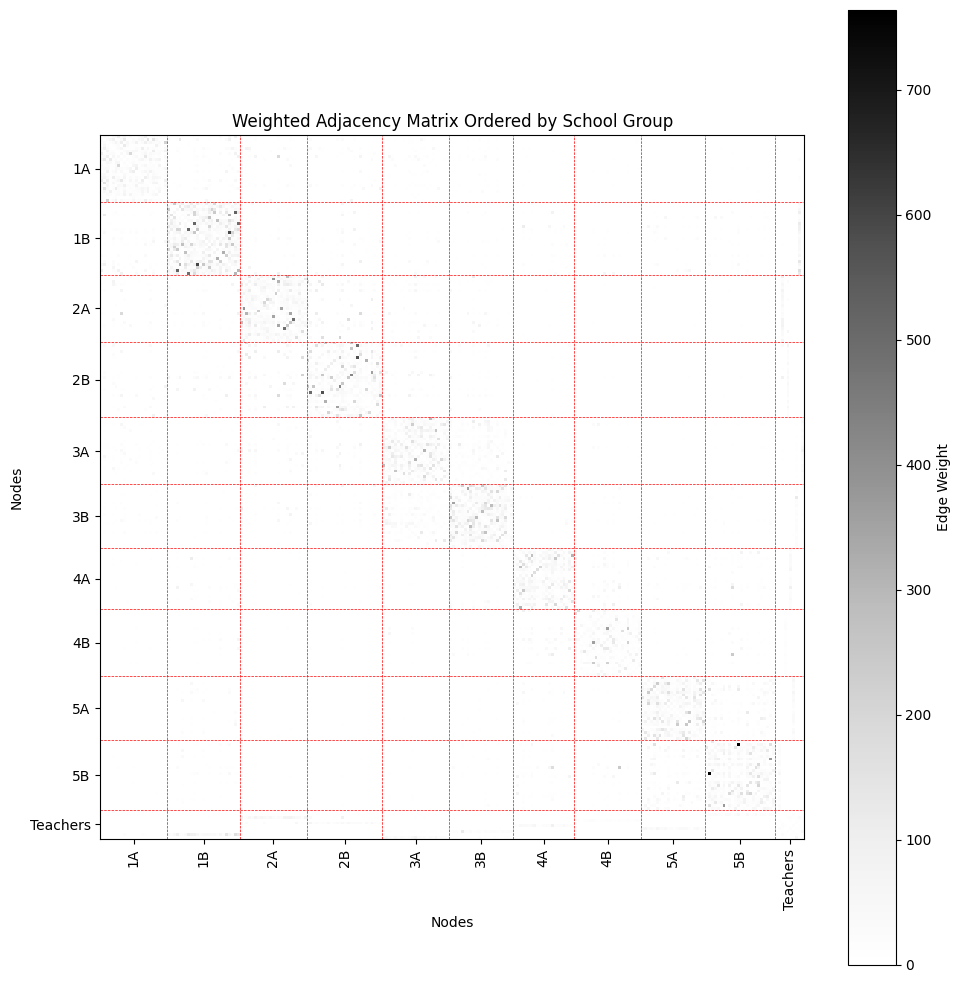

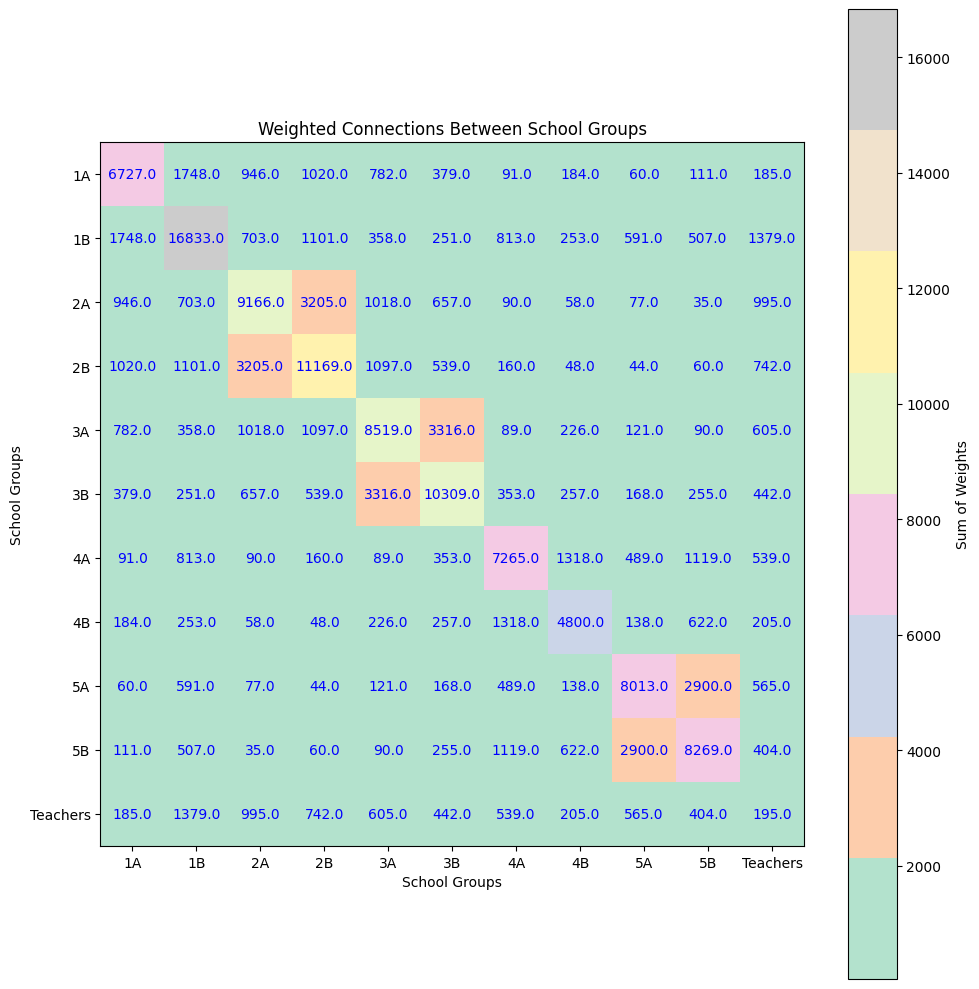

In [11]:
# Order nodes by their school group (using metadata)
sorted_nodes = sorted(G_w.nodes(), key=lambda node: (metadata.get(node, ""), node))

# Get the weighted adjacency matrix of G_w explicitly using the "weight" attribute
A = nx.to_numpy_array(G_w, nodelist=sorted_nodes, weight='weight')

plt.figure(figsize=(10, 10))
plt.imshow(A, interpolation='none', cmap='Greys')
plt.title("Weighted Adjacency Matrix Ordered by School Group")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# Get group labels for the sorted nodes
group_labels = [metadata.get(node, "") for node in sorted_nodes]

# Compute group boundaries and positions for tick labels
group_positions = []
boundaries = []
for group, subiter in itertools.groupby(enumerate(group_labels), key=lambda x: x[1]):
    sublist = list(subiter)
    idx_start = sublist[0][0]
    idx_end = sublist[-1][0]
    mid = (idx_start + idx_end) / 2
    group_positions.append((group, mid))
    boundaries.append(idx_end + 0.5)
    
# Draw boundary lines to separate groups
for b in boundaries:
    plt.axhline(b, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(b, color='red', linestyle='--', linewidth=0.5)

# Set tick positions and labels at the center of each group block
groups, ticks = zip(*group_positions)
plt.xticks(ticks, groups, rotation=90)
plt.yticks(ticks, groups)

plt.colorbar(label="Edge Weight")
plt.tight_layout()
plt.show()


# --- New code: Compute and plot weighted connection sums between different school groups ---

# Use the same group order as in group_positions
groups_order = [group for group, _ in group_positions]
n_groups = len(groups_order)
conn_matrix = np.zeros((n_groups, n_groups), dtype=float)  # float type for accumulated weights

# Iterate over all edges and sum the weights for each pair of school groups
for u, v, data in G_w.edges(data=True):
    # Retrieve the school group for both nodes (if available)
    gu = G_w.nodes[u].get("school_group")
    gv = G_w.nodes[v].get("school_group")
    if gu is None or gv is None:
        continue
    weight = data.get("weight", 1)  # Use edge weight (default to 1 if not provided)
    i = groups_order.index(gu)
    j = groups_order.index(gv)
    # Add weight once for self connections; else add to both symmetric entries
    if i == j:
        conn_matrix[i, j] += weight
    else:
        conn_matrix[i, j] += weight
        conn_matrix[j, i] += weight

plt.figure(figsize=(10, 10))
plt.imshow(conn_matrix, cmap='Pastel2', interpolation='nearest')
plt.colorbar(label='Sum of Weights')
plt.xticks(np.arange(n_groups), groups_order)
plt.yticks(np.arange(n_groups), groups_order)
plt.title("Weighted Connections Between School Groups")
plt.xlabel("School Groups")
plt.ylabel("School Groups")

# Add the actual numerical value in each cell formatted to two decimals
for i in range(n_groups):
    for j in range(n_groups):
        plt.text(j, i, f"{conn_matrix[i, j]:.1f}", ha='center', va='center', color='b', fontsize=10)

plt.tight_layout()
plt.show()